In [20]:
# importing libraries.....
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

In [2]:
# for downloading data.....
# !git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
# !ls pubmed-rct

The goal of this model is to classify the sentences which appear in the sequences, like what role each sentences serve in the abstract

## What we're going to do:
    ~ Download Dataset
    ~ Writing Preprocessing Function to prepare data for modelling
    ~ Setup Series of Model Experiment
    ~ Make MultiModel Model
    ~ Make Prediction

In [5]:
# check out the files in the dataset
# !ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign

Well we've three files there first one is for development set which is another name for validation data while 2nd and 3rd files contain data for testing and training respectively.

In [6]:
# check all filenames in the directory....
# data_dir = "pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"
# filenames = [data_dir + fname for fname in os.listdir(data_dir)]
# filenames

In [7]:
!ls

README.md     dev.txt       test.txt
SkimLit.ipynb pubmed-rct    train.txt


## Preprocessing Data:

In [8]:
# let's make a function that will preprocess the data
def get_lines(fname):
    """
    reads the filename and return the lines of the text as a list
    """
    with open(fname,"r") as file:
        return file.readlines()

In [9]:
!ls

README.md     dev.txt       test.txt
SkimLit.ipynb pubmed-rct    train.txt


In [10]:
# get the lines 
train_lines = get_lines("train.txt")
train_lines[:5]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n']

In [11]:
train_lines[:2]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n']

In [12]:
def preprocess_text(filename):
  input_lines = get_lines(filename) # get all lines from filename
  abstract_lines = "" # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts
  
  # Loop through each line in target file
  for line in input_lines:
    if line.startswith("###"): # check to see if line is an ID line
      abstract_id = line
      abstract_lines = "" # reset abstract string
    elif line.isspace(): # check to see if line is a new line
      abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines

      # Iterate through each line in abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create empty dict to store data from line
        target_text_split = abstract_line.split("\t") # split target label from text
        line_data["target"] = target_text_split[0] # get target label
        line_data["text"] = target_text_split[1].lower() # get target text and lower it
        line_data["line_number"] = abstract_line_number # what number line does the line appear in the abstract?
        line_data["total_lines"] = len(abstract_line_split) - 1 # how many total lines are in the abstract? (start from 0)
        abstract_samples.append(line_data) # add line data to abstract samples list
    
    else: # if the above conditions aren't fulfilled, the line contains a labelled sentence
      abstract_lines += line
  
  return abstract_samples

In [13]:
# get the data from files and preprocess it
train_samples = preprocess_text("train.txt")
val_samples = preprocess_text("dev.txt")
test_samples = preprocess_text("test.txt")

# checking the length of each sample
len(train_samples),len(val_samples),len(test_samples)

(180040, 30212, 30135)

In [14]:
# convert them into pandas data-frame
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

# check out the head of train df
train_df

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
...,...,...,...,...
180035,RESULTS,for the absolute change in percent atheroma vo...,7,11
180036,RESULTS,"for pav , a significantly greater percentage o...",8,11
180037,RESULTS,both strategies had acceptable side effect pro...,9,11
180038,CONCLUSIONS,"compared with standard statin monotherapy , th...",10,11


In [15]:
# checking the destribution of the target values...
train_df["target"].value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

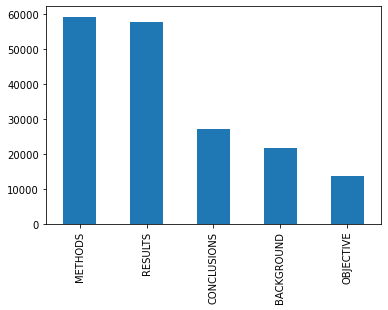

In [16]:
# let's visulize it...
train_df["target"].value_counts().plot(kind="bar");

In [17]:
# get the sentences from data-frame line X values
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()

# viewing couple of few lines...
train_sentences[:5]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .']

In [18]:
# get the "Target" Y values and convert them into One-Hot-Encoder
encoder = LabelEncoder()
train_labels = encoder.fit_transform(train_df["target"].to_numpy())
test_labels = encoder.transform(test_df["target"].to_numpy())
val_labels = encoder.transform(val_df["target"].to_numpy())

train_labels

array([3, 2, 2, ..., 4, 1, 1])

In [19]:
encoder.classes_

array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
      dtype=object)

## Model Experiments:

## Model 0 : BaseLine Model

our first baseline model will be scikit-learn Naive Bayes Model.

In [24]:
# baseline model
model_0 = Pipeline([
    ("tfidf",TfidfVectorizer()),
    ("model",MultinomialNB())
])

# fitting the model on data....
model_0.fit(train_sentences,train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('model', MultinomialNB())])

In [27]:
# evaluate baseline model...
model_0.score(val_sentences,val_labels) * 100

72.1832384482987